### data : titanic

1. 독립변수
  - Pclass : 좌석등급(1 = 1등석, 2, 3 - 사회적 계층을 대표(1 = upper, 2 = middle, 3 = lower))
  - sex : 성별
  - age : 나이
  - sibsp : 형제 자매, 배우자 수
  - parch : 부모와 자식 수(일부 유모와 탑승한 변수의 값은 0)
  - ticket : 티켓 번호
  - fare : 요금
  - cabin : 객실 번호
  - embarked : 정박항구(c, q, s)
  
2. 종속변수
  - survival : 생존여부(0 = 사망, 1 = 생존)

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
from scipy import stats

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from xgboost import plot_importance

plt.rc('font',family='Malgun Gothic')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 로드

In [92]:
df_train = pd.read_csv("C:/Users/Park/_Python_data/titanic/train.csv")  
df_test = pd.read_csv("C:/Users/Park/_Python_data/titanic/test.csv")
df_gender = pd.read_csv("C:/Users/Park/_Python_data/titanic/gender.csv")

In [93]:
# df_test 데이터의 Survived 변수는 df_gender에 있다.
# 따라서 이를 모두 결합하여 df 데이터를 생성한다.

df_test['Survived'] = df_gender.Survived
df = pd.concat([df_train,df_test],axis = 0)
df.reset_index(inplace=True,drop=True)
df.index +=1
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1308,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## 2. 결측값 확인

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


<AxesSubplot:>

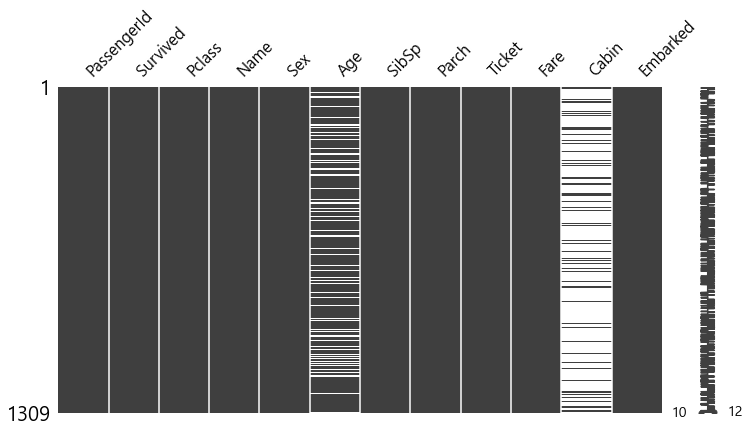

In [94]:
print(df.isnull().sum())
msno.matrix(df, figsize =(12,6))

* null 값이 포함된 행 제거
* cabin feature는 결측값이 많기 때문에 제거한다.

In [95]:
df_titanic = df.drop(['Cabin'],axis = 1)
df_titanic = df_titanic.dropna()
df_titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## 3. EDA

### (1) 기술통계량

In [96]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 1 to 1307
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1043 non-null   int64  
 1   Survived     1043 non-null   int64  
 2   Pclass       1043 non-null   int64  
 3   Name         1043 non-null   object 
 4   Sex          1043 non-null   object 
 5   Age          1043 non-null   float64
 6   SibSp        1043 non-null   int64  
 7   Parch        1043 non-null   int64  
 8   Ticket       1043 non-null   object 
 9   Fare         1043 non-null   float64
 10  Embarked     1043 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 97.8+ KB


In [97]:
# 기술통계량에 왜도, 첨도, 중앙값을 추가한다.
# 기술통계 데이터는 df_stats로 새롭게 생성한다.

df_stats = df_titanic.describe().T

skew = []
kurtosis = []
median = []

for i in df_stats.index:
    skew.append(df_titanic[i].skew())
    kurtosis.append(df_titanic[i].kurtosis())
    median.append(df_titanic[i].median())

df_stats['median'] = median    
df_stats['skewness'] = skew
df_stats['kurtosis'] = kurtosis

df_stats

,count,mean,std,min,25%,50%,75%,max,median,skewness,kurtosis
PassengerId,1043.0,655.391179,377.527036,1.00,326.50,662.00,973.5000,1307.0000,662.00,-0.000728,-1.195035
Survived,1043.0,0.397891,0.489697,0.00,0.00,0.00,1.0000,1.0000,0.00,0.417831,-1.828928
Pclass,1043.0,2.209012,0.840685,1.00,1.00,2.00,3.0000,3.0000,2.00,-0.409915,-1.465153
Age,1043.0,29.813202,14.366254,0.17,21.00,28.00,39.0000,80.0000,28.00,0.406883,0.161351
SibSp,1043.0,0.504314,0.913080,0.00,0.00,0.00,1.0000,8.0000,0.00,2.806470,10.537440
Parch,1043.0,0.421860,0.840655,0.00,0.00,0.00,1.0000,6.0000,0.00,2.660404,9.339196
Fare,1043.0,36.603024,55.753648,0.00,8.05,15.75,35.0771,512.3292,15.75,4.122509,23.691411


### (2) 변수별 생존 확률 파악

In [98]:
display(df_titanic[['Pclass','Survived']].groupby(by=['Pclass']).mean().sort_values(by='Survived',ascending=False))
display(df_titanic[['Sex','Survived']].groupby(by=['Sex']).mean().sort_values(by='Survived',ascending=False))
display(df_titanic[['SibSp','Survived']].groupby(by=['SibSp']).mean().sort_values(by='Survived',ascending=False))
display(df_titanic[['Parch','Survived']].groupby(by=['Parch']).mean().sort_values(by='Survived',ascending=False))

,Survived
Pclass,
1,0.595745
2,0.429119
3,0.270000


,Survived
Sex,
female,0.834197
male,0.141553


,Survived
SibSp,
1,0.525000
2,0.444444
0,0.354839
3,0.312500
4,0.181818
5,0.166667
8,0.000000


,Survived
Parch,
3,0.625000
2,0.577320
1,0.556250
0,0.343791
4,0.200000
5,0.166667
6,0.000000


### (3) 타겟변수의 균형 파악
- 만일 타깃변수가 불균형을 이루고 있다면 분류 모델을 학습할 경우 분류 성능이 저하된다.
- 이를 Imbalanced problem 이라 한다.
- 이때 균형을 맞추기 위해서는 Resampling method(Over, Under, Hybrid resampling)과 같은 방법을 사용한다.

- 해당 문제에서는 큰 불균형을 보이지 않기 때문에 그대로 진행한다.

In [99]:
print('사망 확률 :',df_titanic.Survived.value_counts()[0] / df_titanic.Survived.count() * 100)
print('생존 확률 :',df_titanic.Survived.value_counts()[1] / df_titanic.Survived.count() * 100)

사망 확률 : 60.21093000958773
생존 확률 : 39.78906999041227


## 4. 데이터 전처리

### (1) 호칭분류
- 호칭에 따른 더미변수가 거대해지는 것을 방지하기 위해 불필요한 호칭은 제거한다.
- Mr, Miss, Master, Other로 구분

In [100]:
arr_title = list()

for i in df_titanic.Name.values:
    title = i.split(',')[1].split('.')[0].replace(' ','')       # split(',')[0] : ,(콤마) 기준으로 분리 후 앞의 데이터([0])를 출력
    arr_title.append(title)                                     # .replace(' ','') : 공백을 없애주는 과정. 필수!!
    
arr_title

df_titanic['title'] = arr_title

In [101]:
df_titanic.title = df_titanic.title.replace(['Rev','Dr','Col','Major','Sir','Don','Lady','theCountess','Jonkheer','Dona','Capt'],'Others')
df_titanic.title = df_titanic.title.replace('Mlle','Miss')
df_titanic.title = df_titanic.title.replace('Ms','Miss')
df_titanic.title = df_titanic.title.replace('Mme','Mrs')

### (2) label encoding
- 성별값 라벨 인코딩

In [102]:
label_enco = LabelEncoder()
df_titanic.Sex = label_enco.fit_transform(df_titanic.Sex)
df_titanic.Embarked = label_enco.fit_transform(df_titanic.Embarked)
display(label_enco.inverse_transform([0,1,2]))                # 라벨값 확인
display(df_titanic)

array(['C', 'Q', 'S'], dtype=object)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,title
1,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,Mr
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,Mrs
3,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,Miss
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,Mrs
5,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
1301,1301,1,3,"Peacock, Miss. Treasteall",0,3.0,1,1,SOTON/O.Q. 3101315,13.7750,2,Miss
1303,1303,1,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,37.0,1,0,19928,90.0000,1,Mrs
1304,1304,1,3,"Henriksson, Miss. Jenny Lovisa",0,28.0,0,0,347086,7.7750,2,Miss
1306,1306,1,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,0,Others


### (3) onehot encoding

In [103]:
df_one = df_titanic[['Pclass', 'title', 'Embarked']]

one_enco = OneHotEncoder()
one_df = one_enco.fit_transform(df_one)
one_df = pd.DataFrame(one_df.toarray(), columns = one_enco.get_feature_names(df_one.columns),index=df_titanic.index)

df_titanic = pd.concat([df_titanic, one_df],axis=1)
df_titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_2,Pclass_3,title_Master,title_Miss,title_Mr,title_Mrs,title_Others,Embarked_0,Embarked_1,Embarked_2
1,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,1301,1,3,"Peacock, Miss. Treasteall",0,3.0,1,1,SOTON/O.Q. 3101315,13.7750,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1303,1303,1,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,37.0,1,0,19928,90.0000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1304,1304,1,3,"Henriksson, Miss. Jenny Lovisa",0,28.0,0,0,347086,7.7750,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1306,1306,1,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## 5. 시각화를 통한 데이터 특징 파악

C:\Users\Park\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Park\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

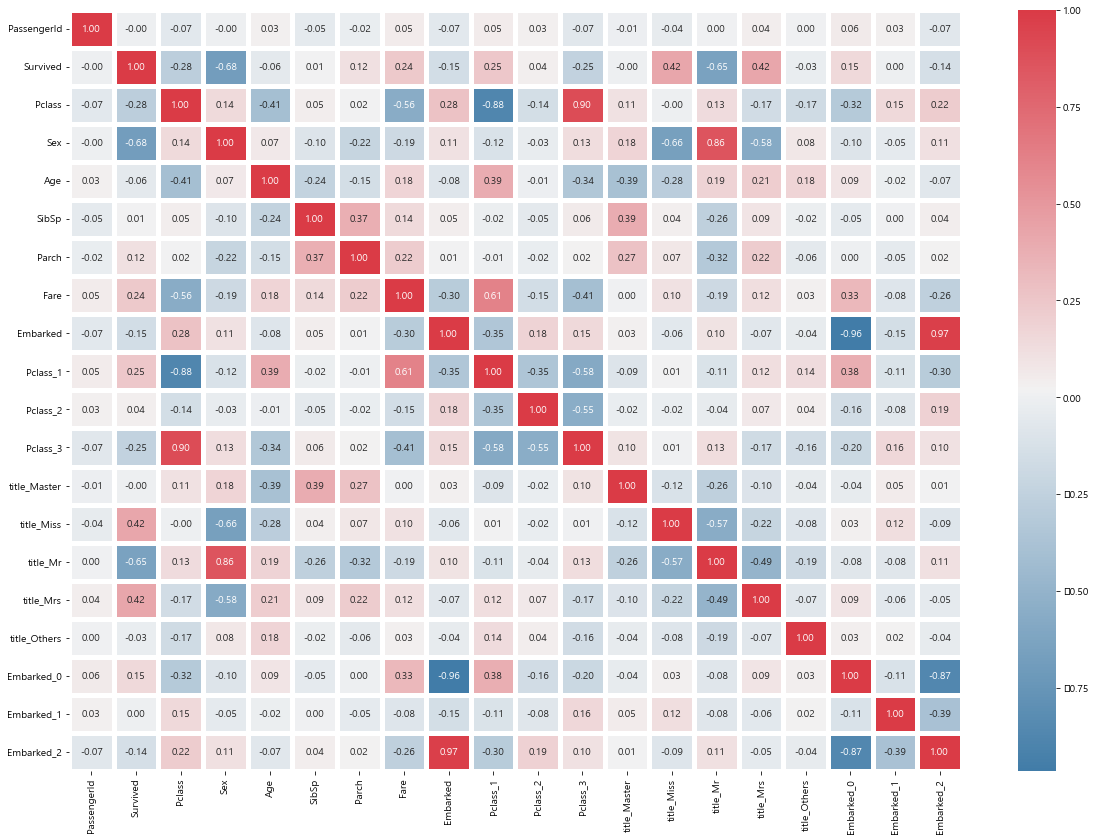

In [104]:
cmap = sns.diverging_palette(240,10,n=9,as_cmap=True)

plt.figure(figsize=(20,14))
sns.heatmap(df_titanic.corr(), cmap = cmap, annot=True, annot_kws={'size':10},linewidth=5,fmt='.2f')

* 타겟변수와의 상관관계 파악

In [105]:
df_titanic.corr().Survived.sort_values(ascending=False)

Survived        1.000000
title_Miss      0.421761
title_Mrs       0.420865
Pclass_1        0.246069
Fare            0.238495
Embarked_0      0.154045
Parch           0.116394
Pclass_2        0.036859
SibSp           0.012254
Embarked_1      0.000967
title_Master   -0.000787
PassengerId    -0.004425
title_Others   -0.025946
Age            -0.055687
Embarked_2     -0.143412
Embarked       -0.153514
Pclass_3       -0.250729
Pclass         -0.279133
title_Mr       -0.645696
Sex            -0.683255
Name: Survived, dtype: float64

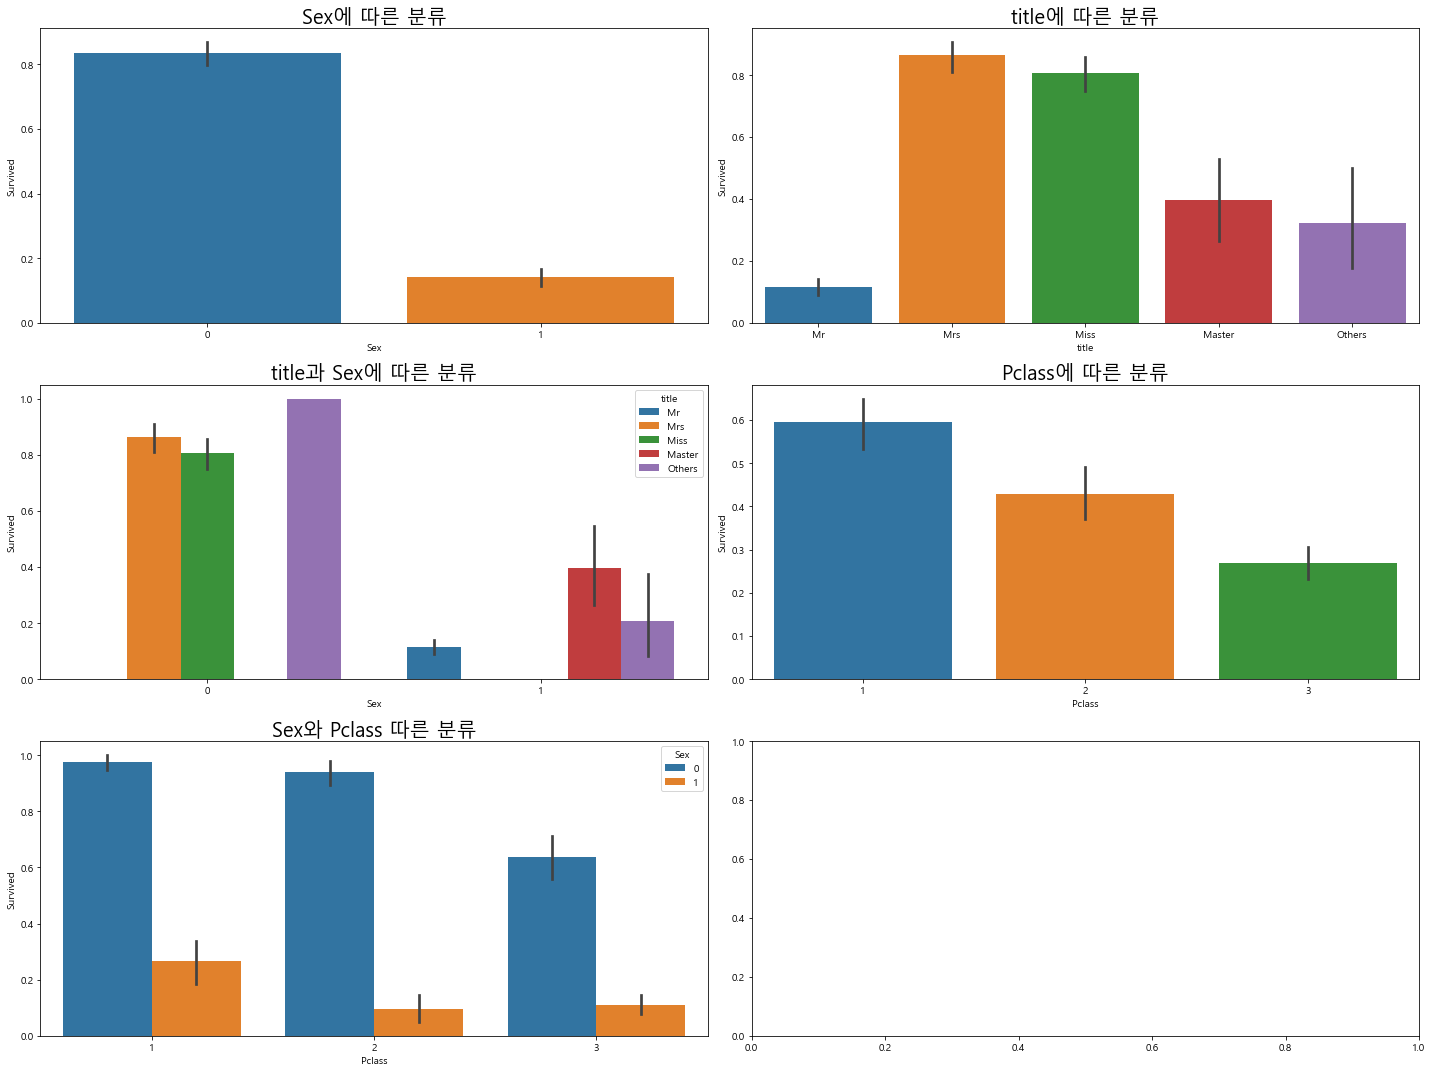

In [106]:
fig, axes = plt.subplots(3,2,figsize=(20,15))
ax1 = axes[0,0]
ax1.set_title('Sex에 따른 분류',size=20)
ax2 = axes[0,1]
ax2.set_title('title에 따른 분류',size=20)
ax3 = axes[1,0]
ax3.set_title('title과 Sex에 따른 분류',size=20)
ax4 = axes[1,1]
ax4.set_title('Pclass에 따른 분류',size=20)
ax5 = axes[2,0]
ax5.set_title('Sex와 Pclass 따른 분류',size=20)

sns.barplot(x = 'Sex', y = 'Survived', data = df_titanic, ax = ax1)

sns.barplot(x = 'title', y = 'Survived', data = df_titanic, ax = ax2)
sns.barplot(x = 'Sex', y = 'Survived', data = df_titanic, hue = 'title', ax = ax3)
sns.barplot(x = 'Pclass',y = 'Survived', data = df_titanic, ax = ax4)
sns.barplot(x = 'Pclass',y = 'Survived', data = df_titanic, hue ='Sex',ax = ax5)
plt.tight_layout()

* feature별 생존자 수 확인

In [107]:
df_pivot = df_titanic[['Survived','Sex','Pclass','title']]
display(df_pivot.pivot_table(values = 'title',index='Sex',columns='Survived',aggfunc='count',margins = True))
display(df_pivot.pivot_table(values = 'Sex',index='Pclass',columns='Survived',aggfunc='count',margins = True))
display(df_pivot.pivot_table(values = 'Sex',index='title',columns='Survived',aggfunc='count',margins = True))

Survived,0,1,All
Sex,,,
0,64,322,386
1,564,93,657
All,628,415,1043


Survived,0,1,All
Pclass,,,
1,114,168,282
2,149,112,261
3,365,135,500
All,628,415,1043


Survived,0,1,All
title,,,
Master,32,21,53
Miss,41,171,212
Mr,513,67,580
Mrs,23,147,170
Others,19,9,28
All,628,415,1043


## 6. 모델 구축

- EDA로 통해 성별, 요금, 가족 유무 등이 타겟변수와 상관관계가 있다.
- 따라서 이를 추출하여 Classification 모델을 구축한다.

In [109]:
df_titanic= df_titanic[['Survived','Age','SibSp','Parch','Fare','Pclass_2','Pclass_3','Sex']]
X = df_titanic.drop(['Survived'],axis = 1)
y = df_titanic.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state = 2021)

In [209]:
def get_clf_eval(y_test,pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    auc = roc_auc_score(y_test,pred)
    print('Accuracy : {0:.4f} / Precision : {1:.4f} / Recall : {2:.4f} / Auc : {3:.4f}'.format(accuracy, precision, recall,auc))

In [215]:
evals = [(X_train,y_train)]

rdf = RandomForestClassifier(n_estimators = 1000)
xgb = XGBClassifier(n_estimators = 1000, eval_metric ='logloss', learning_rate = 0.05, max_depth = 5)
lgbm = LGBMClassifier(n_estimators = 1000, learning_rate = 0.05, max_depth = 5)

models = {'rdf' : rdf, 'xgb' : xgb, 'lgbm' : lgbm}

for model in models.values():
    if model == rdf:
        model.fit(X_train,y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        print('-'*30)
        get_clf_eval(y_train, train_pred)
        get_clf_eval(y_test, test_pred)
    else:
        model.fit(X_train,y_train, early_stopping_rounds=50, eval_set = evals,verbose = False)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        print('-'*30)
        get_clf_eval(y_train, train_pred)
        get_clf_eval(y_test, test_pred)


------------------------------
Accuracy : 0.9868 / Precision : 0.9940 / Recall : 0.9736 / Auc : 0.9848
Accuracy : 0.8086 / Precision : 0.7024 / Recall : 0.7973 / Auc : 0.8061
------------------------------
Accuracy : 0.9712 / Precision : 0.9877 / Recall : 0.9413 / Auc : 0.9666
Accuracy : 0.8373 / Precision : 0.7564 / Recall : 0.7973 / Auc : 0.8283
------------------------------
Accuracy : 0.9772 / Precision : 0.9879 / Recall : 0.9560 / Auc : 0.9739
Accuracy : 0.8373 / Precision : 0.7564 / Recall : 0.7973 / Auc : 0.8283


- Randomforest가 가장 성능이 우수했지만 train set과 test set의 성능평가 지표가 크기 때문에 오버피팅이 의심된다.
- lightgbm 또한 성능이 우수하지만, 데이터가 작기 때문에 오버피팅의 위험이 존재한다.
- 따라서 xgboost를 사용해 파라미터를 튜닝한 결과 test set에 대한 성능지표는 다음과 같다.
- Accuracy : 0.8565 / Precision : 0.7895 / Recall : 0.8108 / Auc : 0.8461

In [223]:
xgb = XGBClassifier(n_estimators = 1000, eval_metric ='logloss', learning_rate = 0.05, max_depth = 3, subsample=0.5,colsample_bytree=0.5)
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_set = evals, verbose =1)
pred = xgb.predict(X_test)
get_clf_eval(y_test, pred)

[0]	validation_0-logloss:0.66712
[1]	validation_0-logloss:0.66091
[2]	validation_0-logloss:0.65572
[3]	validation_0-logloss:0.63238
[4]	validation_0-logloss:0.61206
[5]	validation_0-logloss:0.60797
[6]	validation_0-logloss:0.58955
[7]	validation_0-logloss:0.58353
[8]	validation_0-logloss:0.57945
[9]	validation_0-logloss:0.57463
[10]	validation_0-logloss:0.57130
[11]	validation_0-logloss:0.55610
[12]	validation_0-logloss:0.55244
[13]	validation_0-logloss:0.54897
[14]	validation_0-logloss:0.54675
[15]	validation_0-logloss:0.54382
[16]	validation_0-logloss:0.53077
[17]	validation_0-logloss:0.52794
[18]	validation_0-logloss:0.52596
[19]	validation_0-logloss:0.51313
[20]	validation_0-logloss:0.51097
[21]	validation_0-logloss:0.50911
[22]	validation_0-logloss:0.49801
[23]	validation_0-logloss:0.49569
[24]	validation_0-logloss:0.49412
[25]	validation_0-logloss:0.49238
[26]	validation_0-logloss:0.49100
[27]	validation_0-logloss:0.48125
[28]	validation_0-logloss:0.48031
[29]	validation_0-loglos

[238]	validation_0-logloss:0.28019
[239]	validation_0-logloss:0.27964
[240]	validation_0-logloss:0.27947
[241]	validation_0-logloss:0.27930
[242]	validation_0-logloss:0.27899
[243]	validation_0-logloss:0.27836
[244]	validation_0-logloss:0.27812
[245]	validation_0-logloss:0.27767
[246]	validation_0-logloss:0.27758
[247]	validation_0-logloss:0.27747
[248]	validation_0-logloss:0.27727
[249]	validation_0-logloss:0.27709
[250]	validation_0-logloss:0.27664
[251]	validation_0-logloss:0.27648
[252]	validation_0-logloss:0.27621
[253]	validation_0-logloss:0.27608
[254]	validation_0-logloss:0.27590
[255]	validation_0-logloss:0.27576
[256]	validation_0-logloss:0.27565
[257]	validation_0-logloss:0.27542
[258]	validation_0-logloss:0.27532
[259]	validation_0-logloss:0.27508
[260]	validation_0-logloss:0.27498
[261]	validation_0-logloss:0.27496
[262]	validation_0-logloss:0.27470
[263]	validation_0-logloss:0.27442
[264]	validation_0-logloss:0.27418
[265]	validation_0-logloss:0.27421
[266]	validation_0-l

[473]	validation_0-logloss:0.24468
[474]	validation_0-logloss:0.24463
[475]	validation_0-logloss:0.24464
[476]	validation_0-logloss:0.24455
[477]	validation_0-logloss:0.24431
[478]	validation_0-logloss:0.24428
[479]	validation_0-logloss:0.24421
[480]	validation_0-logloss:0.24418
[481]	validation_0-logloss:0.24409
[482]	validation_0-logloss:0.24407
[483]	validation_0-logloss:0.24406
[484]	validation_0-logloss:0.24399
[485]	validation_0-logloss:0.24383
[486]	validation_0-logloss:0.24369
[487]	validation_0-logloss:0.24359
[488]	validation_0-logloss:0.24349
[489]	validation_0-logloss:0.24350
[490]	validation_0-logloss:0.24351
[491]	validation_0-logloss:0.24342
[492]	validation_0-logloss:0.24336
[493]	validation_0-logloss:0.24336
[494]	validation_0-logloss:0.24329
[495]	validation_0-logloss:0.24313
[496]	validation_0-logloss:0.24311
[497]	validation_0-logloss:0.24304
[498]	validation_0-logloss:0.24306
[499]	validation_0-logloss:0.24305
[500]	validation_0-logloss:0.24299
[501]	validation_0-l

[708]	validation_0-logloss:0.22521
[709]	validation_0-logloss:0.22520
[710]	validation_0-logloss:0.22517
[711]	validation_0-logloss:0.22506
[712]	validation_0-logloss:0.22493
[713]	validation_0-logloss:0.22492
[714]	validation_0-logloss:0.22489
[715]	validation_0-logloss:0.22474
[716]	validation_0-logloss:0.22460
[717]	validation_0-logloss:0.22455
[718]	validation_0-logloss:0.22432
[719]	validation_0-logloss:0.22428
[720]	validation_0-logloss:0.22428
[721]	validation_0-logloss:0.22419
[722]	validation_0-logloss:0.22419
[723]	validation_0-logloss:0.22409
[724]	validation_0-logloss:0.22406
[725]	validation_0-logloss:0.22403
[726]	validation_0-logloss:0.22392
[727]	validation_0-logloss:0.22390
[728]	validation_0-logloss:0.22388
[729]	validation_0-logloss:0.22380
[730]	validation_0-logloss:0.22357
[731]	validation_0-logloss:0.22352
[732]	validation_0-logloss:0.22349
[733]	validation_0-logloss:0.22349
[734]	validation_0-logloss:0.22347
[735]	validation_0-logloss:0.22334
[736]	validation_0-l

[943]	validation_0-logloss:0.21047
[944]	validation_0-logloss:0.21037
[945]	validation_0-logloss:0.21037
[946]	validation_0-logloss:0.20997
[947]	validation_0-logloss:0.20997
[948]	validation_0-logloss:0.20998
[949]	validation_0-logloss:0.20986
[950]	validation_0-logloss:0.20985
[951]	validation_0-logloss:0.20984
[952]	validation_0-logloss:0.20984
[953]	validation_0-logloss:0.20982
[954]	validation_0-logloss:0.20962
[955]	validation_0-logloss:0.20955
[956]	validation_0-logloss:0.20931
[957]	validation_0-logloss:0.20927
[958]	validation_0-logloss:0.20923
[959]	validation_0-logloss:0.20924
[960]	validation_0-logloss:0.20921
[961]	validation_0-logloss:0.20914
[962]	validation_0-logloss:0.20913
[963]	validation_0-logloss:0.20913
[964]	validation_0-logloss:0.20900
[965]	validation_0-logloss:0.20888
[966]	validation_0-logloss:0.20877
[967]	validation_0-logloss:0.20869
[968]	validation_0-logloss:0.20871
[969]	validation_0-logloss:0.20872
[970]	validation_0-logloss:0.20861
[971]	validation_0-l

- 변수 중요도 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

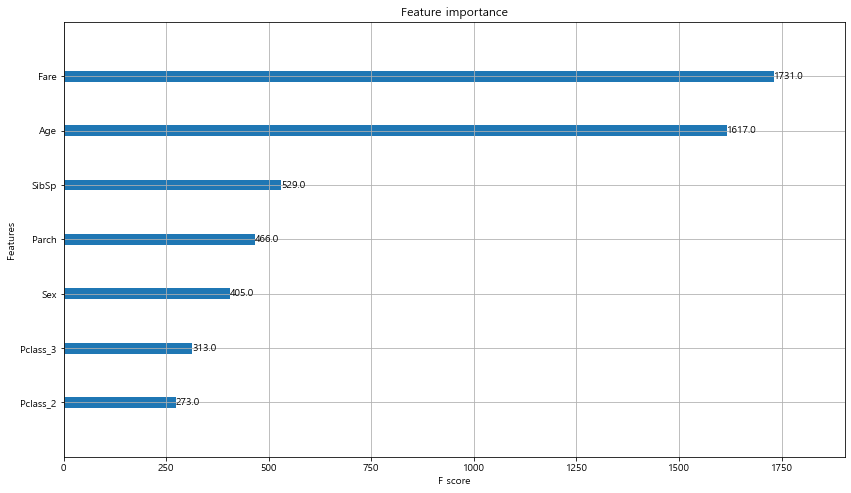

In [202]:
fig, ax = plt.subplots(figsize = (14,8))
plot_importance(xgb, ax= ax)